In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
mp.mp.dps = 50 #higher precision
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from plotDensity import *

In [2]:

#Keep having issues with check energy ranges. Currently only using seeds that worked
#Probably issue of having conflicting preruns?
batch_results_8 = []
for seed in range(100, 448):
    res = []
    all_good = True
    try:
        for error in ["I","X","Y","Z"]:
            filename = "../results/periodic/prob_0.107000/X_8_Y_8/seed_%d"%seed+"/error_class_"+error+"/intervals_5_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
            res.append(read_data_from_file(filename))
    except:
        try:
            for error in ["I","X","Y","Z"]:
                filename = "../results/periodic/prob_0.107000/X_8_Y_8/seed_%d"%seed+"/error_class_"+error+"/intervals_3_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
                res.append(read_data_from_file(filename))
        except:
            print('One or more error classes at 8 by 8 had an issue for seed',seed)
            all_good = False
    
    if all_good:
        batch_results_8.append(res)
        
        
batch_results_10 = []
for seed in range(100, 448):
    res = []
    all_good = True
    try:
        for error in ["I","X","Y","Z"]:
            filename = "../results/periodic/prob_0.107000/X_10_Y_10/seed_%d"%seed+"/error_class_"+error+"/intervals_5_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
            res.append(read_data_from_file(filename))
    except:
        try:
            for error in ["I","X","Y","Z"]:
                filename = "../results/periodic/prob_0.107000/X_10_Y_10/seed_%d"%seed+"/error_class_"+error+"/intervals_3_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
                res.append(read_data_from_file(filename))
        except:
            print('One or more error classes at 10 by 10 had an issue for seed',seed)
            all_good = False
    
    if all_good:
        batch_results_10.append(res)      
        
    
#Log sum exp with arbitrary precision
#Gives infinite temperature version of the free energy, for scaling
#Also useful later on
def log_sum_exp(to_sum):  
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return res


def free_energy(E_list, log_g_list,  T):
    #Need to log sum over g(E)*exp(-E/T) without overflow issues   
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g - E_list[i]/T)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return -T*res

def get_free_energies(rescaled_results,temperatures):
    free_energies = []
    for seed_results in rescaled_results:
        free_energy_classes = []
        for error_result in seed_results:    
            f_values = []
            for T in temperatures:
                f_values.append(free_energy(error_result[0], error_result[1], T)/(-T))
            free_energy_classes.append(f_values)
        free_energies.append(free_energy_classes)
    return free_energies

    
def process_results(batch_results,X,Y):
    rescaled_results = []
    for seed_results in batch_results:
                
        rescaled_seed_results = []
        for error_result in seed_results:    
                        
            walker_results = error_result
            walker_results = get_renormalized_log_g_values_as_dict_list(walker_results)
            walker_results = average_matching_keys(walker_results)
            results_x = []
            results_y = []
            for result in walker_results:
                results_y.append(np.array(list(result.values())))
                results_x.append(np.array(list(result.keys())))
                
            derivatives_wrt_e = get_derivative_wrt_e(walker_results)
            minimum_deviation_energies = find_lowest_inverse_temp_deviation(derivatives_wrt_e)
            rescale_results_for_concatenation(results_x, results_y, minimum_deviation_energies)
            
            x_max = -1 -2*X*Y
            rescaled_x = []
            rescaled_y = []
            for i in range(len(results_x)):
                for j in range(len(results_x[i])):
                    if results_x[i][j] > x_max: #avoid double counting
                        x_max = results_x[i][j]
                        rescaled_x.append(results_x[i][j])
                        rescaled_y.append(results_y[i][j])

            offset = log_sum_exp(rescaled_y)
            rescaled_y = [res + mp.log(2)*X*Y - offset for res in rescaled_y]
            rescaled_seed_results.append([rescaled_x,rescaled_y])
        rescaled_results.append(rescaled_seed_results)
    return rescaled_results
            
rescaled_results_8 = process_results(batch_results_8,8,8)
rescaled_results_10 = process_results(batch_results_10,10,10)

One or more error classes at 8 by 8 had an issue for seed 123
One or more error classes at 8 by 8 had an issue for seed 129


In [3]:
batch_results_12 = []
for seed in range(100, 400):
    res = []
    all_good = True
    try:
        for error in ["I","X","Y","Z"]:
            filename = "../results/periodic/prob_0.107000/X_12_Y_12/seed_%d"%seed+"/error_class_"+error+"/intervals_20_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
            res.append(read_data_from_file(filename))
    except:
        print('One or more error classes at 12 by 12 had an issue for seed',seed)
        all_good = False
    
    if all_good:
        batch_results_12.append(res)
        

        
batch_results_14 = []
for seed in range(100, 400):
    res = []
    all_good = True
    try:
        for error in ["I","X","Y","Z"]:
            filename = "../results/periodic/prob_0.107000/X_14_Y_14/seed_%d"%seed+"/error_class_"+error+"/intervals_20_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
            res.append(read_data_from_file(filename))
    except:
        print('One or more error classes at 14 by 14 had an issue for seed',seed)
        all_good = False
    
    if all_good:
        batch_results_14.append(res)
        
rescaled_results_12 = process_results(batch_results_12,12,12)
rescaled_results_14 = process_results(batch_results_14,14,14)

One or more error classes at 14 by 14 had an issue for seed 125
One or more error classes at 14 by 14 had an issue for seed 153
One or more error classes at 14 by 14 had an issue for seed 175
One or more error classes at 14 by 14 had an issue for seed 280
One or more error classes at 14 by 14 had an issue for seed 398


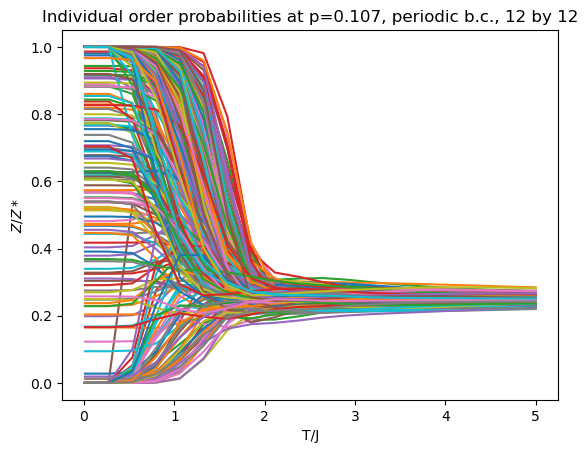

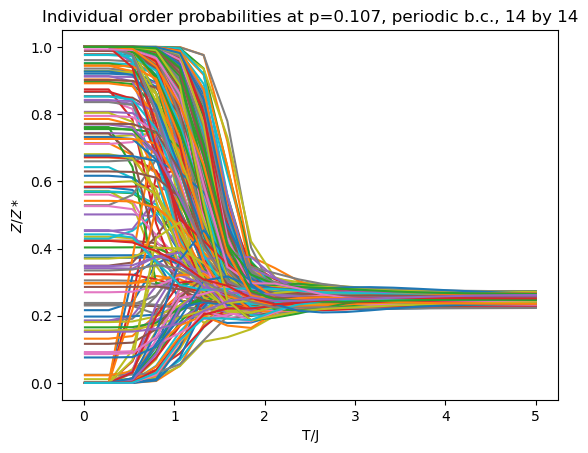

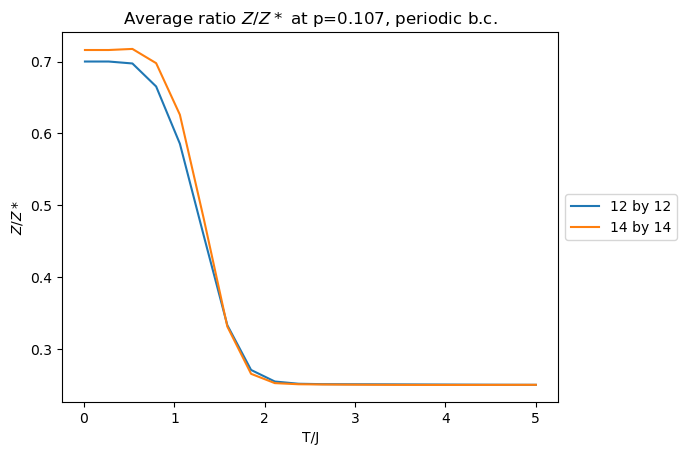

In [4]:
max_temp = 5

temperatures = np.linspace(0.01,max_temp,20)
free_energies_12 = get_free_energies(rescaled_results_12,temperatures)
free_energies_14 = get_free_energies(rescaled_results_14,temperatures)

plt.figure() 
for f_class in free_energies_12:
    plt.plot(temperatures, [1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                              +mp.exp(f_class[2][j] - f_class[0][j])\
                              +mp.exp(f_class[3][j] - f_class[0][j])) \
                            for j in range(len(f_class[0]))])
plt.title("Individual order probabilities at p=0.107, periodic b.c., 12 by 12")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.show()

plt.figure() 
for f_class in free_energies_14:
    plt.plot(temperatures, [1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                              +mp.exp(f_class[2][j] - f_class[0][j])\
                              +mp.exp(f_class[3][j] - f_class[0][j])) \
                            for j in range(len(f_class[0]))])
plt.title("Individual order probabilities at p=0.107, periodic b.c., 14 by 14")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.show()



plt.figure() 
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_12 ])/len(free_energies_12)  \
                        for j in range(len(f_class[0]))], label="12 by 12")
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_14 ])/len(free_energies_14)  \
                        for j in range(len(f_class[0]))], label="14 by 14")
plt.title(r"Average ratio $Z/Z*$ at p=0.107, periodic b.c.")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

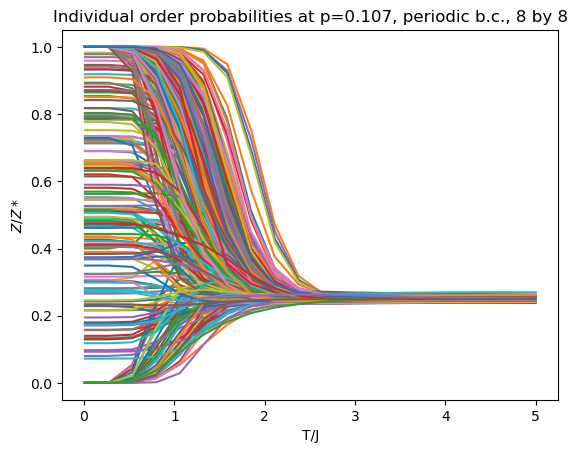

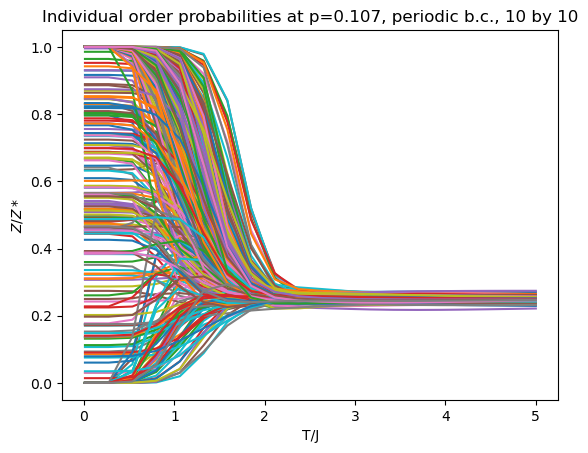

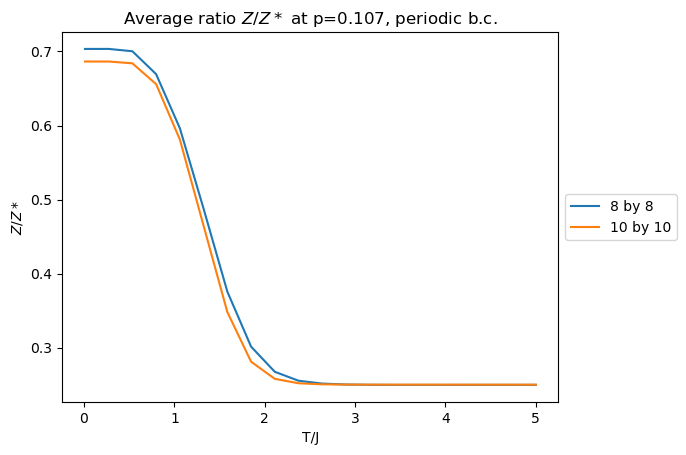

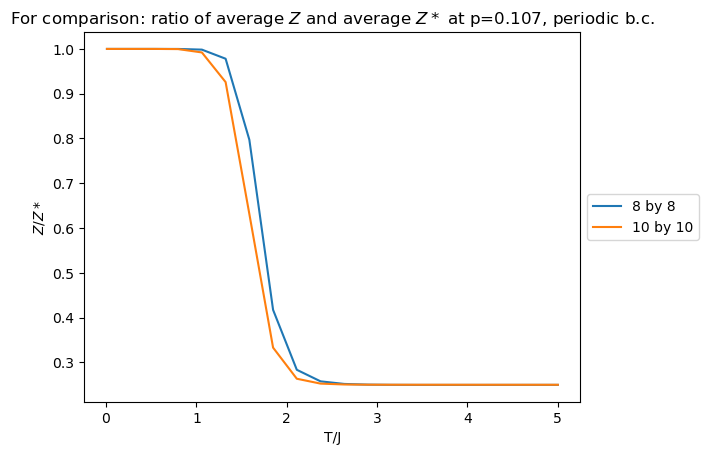

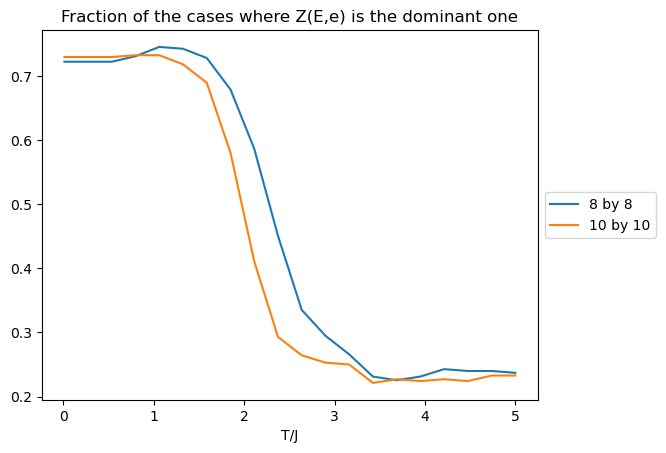

In [5]:
temperatures = np.linspace(0.01,max_temp,20)
free_energies_8 = get_free_energies(rescaled_results_8,temperatures)
free_energies_10 = get_free_energies(rescaled_results_10,temperatures)

plt.figure() 
for f_class in free_energies_8:
    plt.plot(temperatures, [1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                              +mp.exp(f_class[2][j] - f_class[0][j])\
                              +mp.exp(f_class[3][j] - f_class[0][j])) \
                            for j in range(len(f_class[0]))])
plt.title("Individual order probabilities at p=0.107, periodic b.c., 8 by 8")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.show()

plt.figure() 
for f_class in free_energies_10:
    plt.plot(temperatures, [1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                              +mp.exp(f_class[2][j] - f_class[0][j])\
                              +mp.exp(f_class[3][j] - f_class[0][j])) \
                            for j in range(len(f_class[0]))])
plt.title("Individual order probabilities at p=0.107, periodic b.c., 10 by 10")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.show()


####################
# We check the average of the ratio of Z

plt.figure() 
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_8 ])/len(free_energies_8)  \
                        for j in range(len(f_class[0]))], label="8 by 8")
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_10 ])/len(free_energies_10)  \
                        for j in range(len(f_class[0]))], label="10 by 10")
plt.title(r"Average ratio $Z/Z*$ at p=0.107, periodic b.c.")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#We also want to check the order probability of the average, ie ratio of average Z

plt.figure()

f_class = free_energies_8[0]

average_I = [log_sum_exp([f_class[0][j] for f_class in free_energies_8])  for j in range(len(f_class[0]))]
average_X = [log_sum_exp([f_class[1][j] for f_class in free_energies_8])  for j in range(len(f_class[0]))]
average_Y = [log_sum_exp([f_class[2][j] for f_class in free_energies_8])  for j in range(len(f_class[0]))]
average_Z = [log_sum_exp([f_class[3][j] for f_class in free_energies_8])  for j in range(len(f_class[0]))]
average_all = [log_sum_exp([average_I[j],average_X[j],average_Y[j],average_Z[j]]) for j in range(len(average_I))]

plt.plot(temperatures, [mp.exp(average_I[j] - average_all[j]) for j in range(len(average_I))],label="8 by 8")


f_class = free_energies_10[0]

average_I = [log_sum_exp([f_class[0][j] for f_class in free_energies_10])  for j in range(len(f_class[0]))]
average_X = [log_sum_exp([f_class[1][j] for f_class in free_energies_10])  for j in range(len(f_class[0]))]
average_Y = [log_sum_exp([f_class[2][j] for f_class in free_energies_10])  for j in range(len(f_class[0]))]
average_Z = [log_sum_exp([f_class[3][j] for f_class in free_energies_10])  for j in range(len(f_class[0]))]
average_all = [log_sum_exp([average_I[j],average_X[j],average_Y[j],average_Z[j]]) for j in range(len(average_I))]

plt.plot(temperatures, [mp.exp(average_I[j] - average_all[j]) for j in range(len(average_I))],label="10 by 10")

plt.title(r"For comparison: ratio of average $Z$ and average $Z*$ at p=0.107, periodic b.c.")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


############
#For comparison, we also count how often any individual ratio is off.

plt.figure()
plt.plot(temperatures, [1 - sum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_8])/(len(free_energies_8))\
                        for j in range(len(f_class[0])) ] , label = "8 by 8")
plt.plot(temperatures, [1 - sum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_10])/(len(free_energies_10))\
                        for j in range(len(f_class[0])) ] , label = "10 by 10")
plt.title("Fraction of the cases where Z(E,e) is the dominant one")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


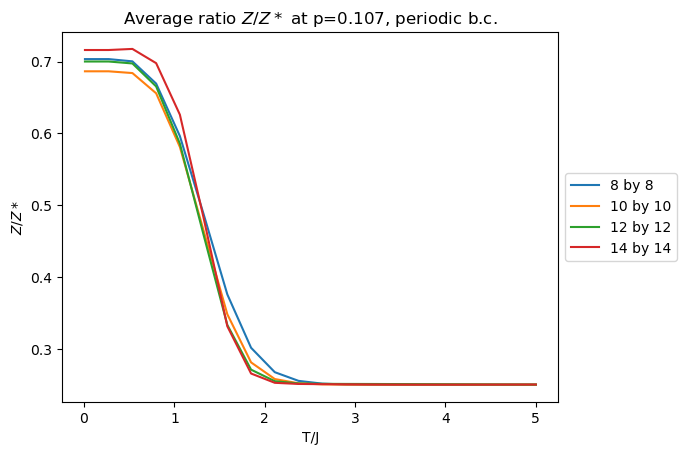

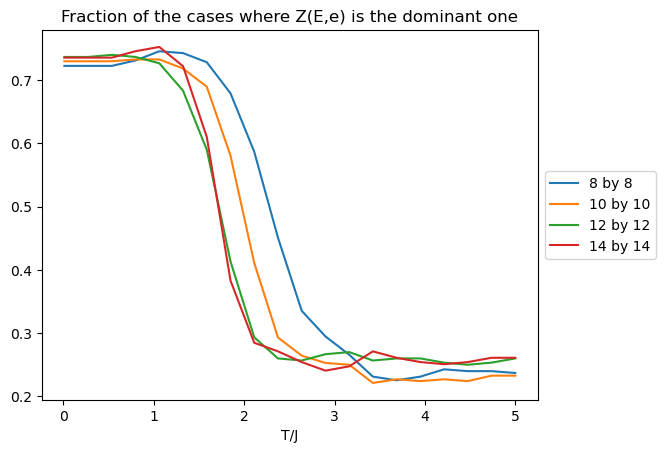

In [6]:
plt.figure() 
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_8 ])/len(free_energies_8)  \
                        for j in range(len(f_class[0]))], label="8 by 8")
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_10 ])/len(free_energies_10)  \
                        for j in range(len(f_class[0]))], label="10 by 10")
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_12 ])/len(free_energies_12)  \
                        for j in range(len(f_class[0]))], label="12 by 12")
plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_14 ])/len(free_energies_14)  \
                        for j in range(len(f_class[0]))], label="14 by 14")
plt.title(r"Average ratio $Z/Z*$ at p=0.107, periodic b.c.")
plt.ylabel(r"$Z/Z*$")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



plt.figure()
plt.plot(temperatures, [1 - sum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_8])/(len(free_energies_8))\
                        for j in range(len(f_class[0])) ] , label = "8 by 8")
plt.plot(temperatures, [1 - sum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_10])/(len(free_energies_10))\
                        for j in range(len(f_class[0])) ] , label = "10 by 10")
plt.plot(temperatures, [1 - sum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_12])/(len(free_energies_12))\
                        for j in range(len(f_class[0])) ] , label = "12 by 12")
plt.plot(temperatures, [1 - sum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_14])/(len(free_energies_14))\
                        for j in range(len(f_class[0])) ] , label = "14 by 14")


plt.title("Fraction of the cases where Z(E,e) is the dominant one")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [7]:
#For now, take a rough value for the Nishimori temp just by eye -- for this p, it should be around 0.95
j_Nish = 0
min_so_far = 1
for j, temp in enumerate(temperatures):
    #print(j, abs(temp-0.95))
    if abs(temp-0.95)<min_so_far:
        j_Nish = j
    min_so_far = abs(temp-0.95)

print(j_Nish, abs(temperatures[j_Nish]-0.95))

4 0.1105263157894738


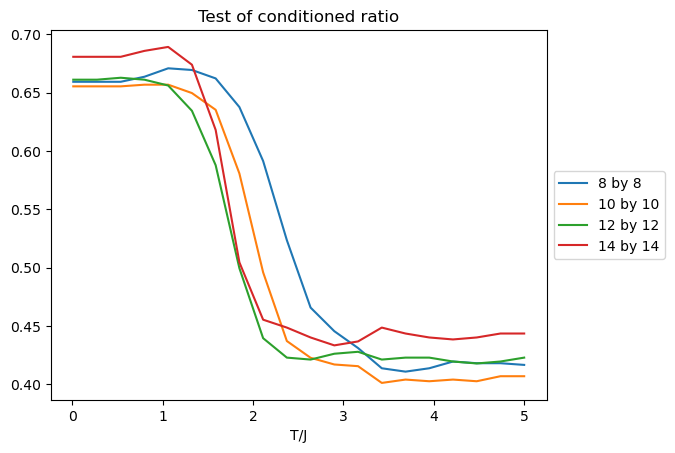

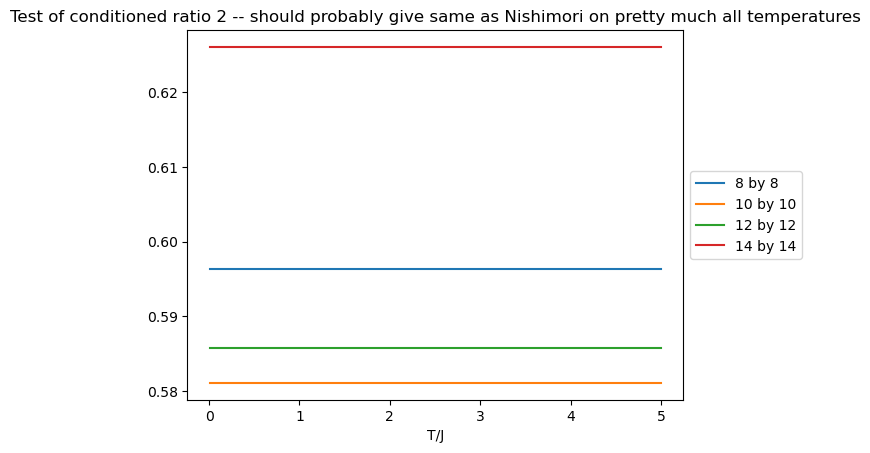

In [8]:
#Done for each f_class (meaning for each seed). Then we average later, when plotting

#In the ratios we do not use j but rather j_Nish,
#with j_Nish being whichever index gets us the Nishimori temperature
#(later, we should compute exactly at the Nishimori point to compare)


#This should in general not agree with the Preskill method away from the Nishimori line
def fractions(f_class):
    res = []
    
    for j in range(len(f_class[0])):
        
        #If condition determines if we are in the equivalence class the dedcoder chooses            
        if f_class[0][j]>f_class[1][j] and f_class[0][j]>f_class[2][j] and f_class[0][j]>f_class[3][j]:
            
            
            result = (1/(1+ mp.exp(f_class[1][j_Nish] - f_class[0][j_Nish])\
                          +mp.exp(f_class[2][j_Nish] - f_class[0][j_Nish])\
                          +mp.exp(f_class[3][j_Nish] - f_class[0][j_Nish])))
        else:
            result = (-(mp.exp(f_class[1][j_Nish] - f_class[0][j_Nish])\
                          +mp.exp(f_class[2][j_Nish] - f_class[0][j_Nish])\
                          +mp.exp(f_class[3][j_Nish] - f_class[0][j_Nish]))
                      /(1 + mp.exp(f_class[1][j_Nish] - f_class[0][j_Nish])\
                          +mp.exp(f_class[2][j_Nish] - f_class[0][j_Nish])\
                          +mp.exp(f_class[3][j_Nish] - f_class[0][j_Nish])))
        res.append(result)
    return res



def fractions_new(f_class):
    res = []
    
    for j in range(len(f_class[0])):
    
        #Decoder picks a class based on temperature j
        classes = [f_class[0][j],f_class[0][j],f_class[0][j],f_class[0][j]]

        i_max = classes.index(max(classes))

        #We find the likelihood of actually being in that class (Makes sense only for Nishimori)
        result = (1/(mp.exp(f_class[0][j_Nish] - f_class[i_max][j_Nish])\
                      + mp.exp(f_class[1][j_Nish] - f_class[i_max][j_Nish])\
                      +mp.exp(f_class[2][j_Nish] - f_class[i_max][j_Nish])\
                      +mp.exp(f_class[3][j_Nish] - f_class[i_max][j_Nish])))

        res.append(result)
    return res





def fraction_new(f_class):
    
    #Decoder picks a class based on temperature j
    classes = [f_class[0][j],f_class[0][j],f_class[0][j],f_class[0][j]]

    i_max = classes.index(max(classes))

    #We find the likelihood of actually being in that class (Makes sense only for Nishimori)
    result = (1/(mp.exp(f_class[0][j_Nish] - f_class[i_max][j_Nish])\
                  + mp.exp(f_class[1][j_Nish] - f_class[i_max][j_Nish])\
                  +mp.exp(f_class[2][j_Nish] - f_class[i_max][j_Nish])\
                  +mp.exp(f_class[3][j_Nish] - f_class[i_max][j_Nish])))

    
    return result



temperatures = np.linspace(0.01,max_temp,20)

plt.figure() 
plt.plot(temperatures,  [ 0.5 + 0.5 * np.sum([ fractions(f_class)[j]
                                   for f_class in free_energies_8 ])/len(free_energies_8)  \
                        for j in range(len(f_class[0]))], label="8 by 8")

plt.plot(temperatures,  [ 0.5 + 0.5 * np.sum([ fractions(f_class)[j]
                                   for f_class in free_energies_10 ])/len(free_energies_10)  \
                        for j in range(len(f_class[0]))], label="10 by 10")

plt.plot(temperatures,  [ 0.5 + 0.5 * np.sum([ fractions(f_class)[j]
                                   for f_class in free_energies_12 ])/len(free_energies_12)  \
                        for j in range(len(f_class[0]))], label="12 by 12")

plt.plot(temperatures,  [ 0.5 + 0.5 * np.sum([ fractions(f_class)[j]
                                   for f_class in free_energies_14 ])/len(free_energies_14)  \
                        for j in range(len(f_class[0]))], label="14 by 14")


plt.title("Test of conditioned ratio")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#Test of conditioned ratio 2 -- this one should *definitely* not work outside of
#the Nishimori line, it would just give the same result (in most cases) as on the line
plt.figure() 
plt.plot(temperatures,  [mp.fsum([ fractions_new(f_class)[j]
                                   for f_class in free_energies_8 ])/len(free_energies_8)  \
                        for j in range(len(f_class[0]))], label="8 by 8")

plt.plot(temperatures,  [mp.fsum([ fractions_new(f_class)[j]
                                   for f_class in free_energies_10 ])/len(free_energies_10)  \
                        for j in range(len(f_class[0]))], label="10 by 10")

plt.plot(temperatures,  [mp.fsum([ fractions_new(f_class)[j]
                                   for f_class in free_energies_12 ])/len(free_energies_12)  \
                        for j in range(len(f_class[0]))], label="12 by 12")

plt.plot(temperatures,  [mp.fsum([ fractions_new(f_class)[j]
                                   for f_class in free_energies_14 ])/len(free_energies_14)  \
                        for j in range(len(f_class[0]))], label="14 by 14")


plt.title("Test of conditioned ratio 2 -- should probably give same as Nishimori on pretty much all temperatures")
plt.xlabel("T/J")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



In [9]:
#sanity check that math is mathing, i.,e. that the Z(E,e) dominant curve should also go to 1/4
randvals = np.random.rand(1000000,4)
print(sum([randvals[i][0]>randvals[i][1] or randvals[i][0]>randvals[i][2] or randvals[i][0]>randvals[i][3]\
           for i in range(len(randvals))])/len(randvals))
print(sum([randvals[i][0]<randvals[i][1] and randvals[i][0]<randvals[i][2] and randvals[i][0]<randvals[i][3]\
           for i in range(len(randvals))])/len(randvals))

print(1/(1+1+1+1))


#Next, if trivial class is twice as likely as the other, what do we get?
print(sum([2*randvals[i][0]>randvals[i][1] or 2*randvals[i][0]>randvals[i][2] or 2*randvals[i][0]>randvals[i][3]\
           for i in range(len(randvals))])/len(randvals))
print(sum([2*randvals[i][0]<randvals[i][1] and 2*randvals[i][0]<randvals[i][2] and 2*randvals[i][0]<randvals[i][3]\
           for i in range(len(randvals))])/len(randvals))

print(2/(2+1+1+1))


print('\n')


#sanity check that math is mathing, i.,e. that the Z(E,e) dominant curve should also go to 1/4
randvals = np.random.rand(10000000,2)
print(sum([randvals[i][0]>randvals[i][1] \
           for i in range(len(randvals))])/len(randvals))
print(sum([randvals[i][0]<randvals[i][1] \
           for i in range(len(randvals))])/len(randvals))

print(1/(1+1))


#Next, if trivial class is twice as likely as the other, what do we get?
print(sum([2*randvals[i][0]>randvals[i][1]\
           for i in range(len(randvals))])/len(randvals))
print(sum([2*randvals[i][0]<randvals[i][1]\
           for i in range(len(randvals))])/len(randvals))

print(2/(2+1))

print(sum([2*randvals[i][0]/(2*randvals[i][0] + randvals[i][1])\
           for i in range(len(randvals))])/len(randvals))

print(sum([randvals[i][1]/(2*randvals[i][0] + randvals[i][1])\
           for i in range(len(randvals))])/len(randvals))


print(sum([2*randvals[i][0] for i in range(len(randvals))])/sum([2*randvals[i][0]+randvals[i][1] for i in range(len(randvals))]) )

print(sum([randvals[i][1] for i in range(len(randvals))])/sum([2*randvals[i][0]+randvals[i][1] for i in range(len(randvals))]) )

0.749816
0.250184
0.25
0.875024
0.124976
0.4


0.4998729
0.5001271
0.5
0.7498005
0.2501995
0.6666666666666666
0.6307304923627913
0.36926950763708943
0.6666606458247032
0.33333935417539323


In [10]:
print(7*4*20/60)

#at 4:33: seed 128 for probability 0.
#at 5:25: seed 133, but had been stuck for a while probably.

9.333333333333334


In [11]:
for p in [0,0.02,0.04,0.06,0.08,0.1,0.12]:
    if p == 0:
        T_Nish = 1e-10 #avoid zero division
    else:
        T_Nish = 1/(mp.log((1-p)/p)/2)        
    print(T_Nish)

1e-10
0.51389834236975069304464938937018938665133916493216
0.62931596088824973365382784631385377240273830912679
0.72686692063163383541493662124620866646563046511383
0.81888444641023926992160943541946879123780400080343
0.91023922662683739361424016573610700061263605725521
1.0037992976837764127490265141214035789920569696676


# Looking at a range of probabilities, and comparing to pymatching

In [88]:
from PyMatching import *

num_shots = 200000
Ls = [4,6]
ps = np.linspace(0.01, 0.12, 12)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric_code_x_stabilisers(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    for error_probability in ps:
        num_errors = num_decoding_failures_vectorised(Hx, logX, error_probability, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=6...


In [337]:
batch_results = []

probabilities = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12]

#probabilities = [0.01,0.12]

for p in probabilities:
    
    print('Probability',p)
    
    
    seed_range = range(100,651)
    
    
    
    if p in [0.12]:
        seed_range = range(100,501)    
    
    
    #Taking more shots at low p        
    if p in [0.03]:
        seed_range = list(range(100,651)) + list(range(801,920)) 
        
    if p in [0.01,0.02]:
        seed_range = range(100,1501)
 


    
    seed_range = list(seed_range)+list(range(2000,2265))

        
    new_run = True
    if new_run:
        seed_range = range(100,3100)
        
        
        #seed_range = range(100,600)
    
    
        
    batch_res_4 = []

    for seed in seed_range:
        
        if new_run:
            seed1 = 100
            if seed >= 200:
                seed1 = 200
            if seed >= 400:
                seed1 = 400
            if seed >= 500:
                seed1 = 500
                
                
            seed1 = 0
            
        res = []
        all_good = True

        try:
            for error in ["I","X","Y","Z"]:
                filename = "../results/periodic/prob_%6f"%p+"/X_4_Y_4/seed_%d"%seed+"/error_class_"+error+"/intervals_10_iterations_10000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
                
                if new_run:
                    filename = "../results/periodic/prob_%6f"%p+"/X_4_Y_4/seed_%d"%seed+"/error_class_"+error+"/intervals_10_iterations_10000_overlap_0.250000_walkers_8_seed_run_%d"%seed1+"_alpha_0.800000_beta_0.0000010000exchange_offset1.txt"

                    if seed >= 400:
                        filename = "../results/periodic/prob_%6f"%p+"/X_4_Y_4/seed_%d"%seed+"/error_class_"+error+"/intervals_10_iterations_1000_overlap_0.250000_walkers_8_seed_run_%d"%seed1+"_alpha_0.800000_beta_0.0000010000exchange_offset1.txt"
                    if seed >= 600:
                        filename = "../results/periodic/prob_%6f"%p+"/X_4_Y_4/seed_%d"%seed+"/error_class_"+error+"/intervals_10_iterations_1000_overlap_0.250000_walkers_8_seed_run_0_alpha_0.800000_beta_0.0000010000exchange_offset4.txt"

                    filename = "../results/periodic/prob_%6f"%p+"/X_4_Y_4/seed_%d"%seed+"/error_class_"+error+"/intervals_10_iterations_1000_overlap_0.250000_walkers_8_seed_run_0_alpha_0.800000_beta_0.0000010000exchange_offset4.txt"

                res.append(read_data_from_file(filename))
        except:
            print('One or more error classes at 4 by 4 had an issue for seed',seed,'at probability',p)
            all_good = False

        if all_good:
            batch_res_4.append(res)
    
    batch_res_6 = []
    for seed in seed_range:
        
        if new_run:
            seed1 = 100
            if seed >= 200:
                seed1 = 200
            if seed >= 400:
                seed1 = 400
            if seed >= 500:
                seed1 = 500
        res = []
        all_good = True

        try:
            for error in ["I","X","Y","Z"]:
                filename = "../results/periodic/prob_%6f"%p+"/X_6_Y_6/seed_%d"%seed+"/error_class_"+error+"/intervals_10_iterations_10000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
                
                if new_run:
                    filename = "../results/periodic/prob_%6f"%p+"/X_6_Y_6/seed_%d"%seed+"/error_class_"+error+"/intervals_10_iterations_10000_overlap_0.250000_walkers_8_seed_run_%d"%seed1+"_alpha_0.800000_beta_0.0000010000exchange_offset1.txt"

                    if seed >= 400:
                        filename = "../results/periodic/prob_%6f"%p+"/X_6_Y_6/seed_%d"%seed+"/error_class_"+error+"/intervals_10_iterations_1000_overlap_0.250000_walkers_8_seed_run_%d"%seed1+"_alpha_0.800000_beta_0.0000010000exchange_offset1.txt"
                    if seed >= 600:
                        filename = "../results/periodic/prob_%6f"%p+"/X_6_Y_6/seed_%d"%seed+"/error_class_"+error+"/intervals_10_iterations_1000_overlap_0.250000_walkers_8_seed_run_0_alpha_0.800000_beta_0.0000010000exchange_offset4.txt"

                    filename = "../results/periodic/prob_%6f"%p+"/X_6_Y_6/seed_%d"%seed+"/error_class_"+error+"/intervals_10_iterations_1000_overlap_0.250000_walkers_8_seed_run_0_alpha_0.800000_beta_0.0000010000exchange_offset4.txt"

                        
                res.append(read_data_from_file(filename))
        except:
            print('One or more error classes at 6 by 6 had an issue for seed',seed,'at probability',p)
            all_good = False

        if all_good:
            batch_res_6.append(res)
            

    print('Adding to results for probability',p)
    print('Number of seeds:', len(batch_res_4), len(batch_res_6))
    rescaled_res_4 = process_results(batch_res_4,4,4)
    rescaled_res_6 = process_results(batch_res_6,6,6)
    batch_results.append([rescaled_res_4,rescaled_res_6])

Probability 0.01
Adding to results for probability 0.01
Number of seeds: 3000 3000
Probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1100 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1101 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1102 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1103 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1104 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1105 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1106 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1107 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1108 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1109 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1110 at prob

One or more error classes at 6 by 6 had an issue for seed 1206 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1207 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1208 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1209 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1210 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1211 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1212 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1213 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1214 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1215 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1216 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1217 at probability 0.02
One 

One or more error classes at 6 by 6 had an issue for seed 1306 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1307 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1308 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1309 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1310 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1311 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1312 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1313 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1314 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1315 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1316 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1317 at probability 0.02
One 

One or more error classes at 6 by 6 had an issue for seed 1406 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1407 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1408 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1409 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1410 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1411 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1412 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1413 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1414 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1415 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1416 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1417 at probability 0.02
One 

One or more error classes at 6 by 6 had an issue for seed 1508 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1509 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1510 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1511 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1512 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1513 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1514 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1515 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1516 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1517 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1518 at probability 0.02
One or more error classes at 6 by 6 had an issue for seed 1519 at probability 0.02
One 

One or more error classes at 6 by 6 had an issue for seed 123 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 124 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 125 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 126 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 127 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 128 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 129 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 130 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 131 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 132 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 133 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 134 at probability 0.05
One or more erro

One or more error classes at 6 by 6 had an issue for seed 244 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 245 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 246 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 247 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 248 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 249 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 250 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 251 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 252 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 253 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 254 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 255 at probability 0.05
One or more erro

One or more error classes at 6 by 6 had an issue for seed 360 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 361 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 362 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 363 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 364 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 365 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 366 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 367 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 368 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 369 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 370 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 371 at probability 0.05
One or more erro

One or more error classes at 6 by 6 had an issue for seed 476 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 477 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 478 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 479 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 480 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 481 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 482 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 483 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 484 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 485 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 486 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 487 at probability 0.05
One or more erro

One or more error classes at 6 by 6 had an issue for seed 600 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 601 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 602 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 603 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 604 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 605 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 606 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 607 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 608 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 609 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 610 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 611 at probability 0.05
One or more erro

One or more error classes at 6 by 6 had an issue for seed 722 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 723 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 724 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 725 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 726 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 727 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 728 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 729 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 730 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 731 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 732 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 733 at probability 0.05
One or more erro

One or more error classes at 6 by 6 had an issue for seed 836 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 837 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 838 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 839 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 840 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 841 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 842 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 843 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 844 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 845 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 846 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 847 at probability 0.05
One or more erro

One or more error classes at 6 by 6 had an issue for seed 957 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 958 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 959 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 960 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 961 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 962 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 963 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 964 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 965 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 966 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 967 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 968 at probability 0.05
One or more erro

One or more error classes at 6 by 6 had an issue for seed 1074 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 1075 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 1076 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 1077 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 1078 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 1079 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 1080 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 1081 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 1082 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 1083 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 1084 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 1085 at probability 0.05
One 

One or more error classes at 6 by 6 had an issue for seed 2179 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2180 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2181 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2182 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2183 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2184 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2185 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2186 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2187 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2188 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2189 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2190 at probability 0.05
One 

One or more error classes at 6 by 6 had an issue for seed 2282 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2283 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2284 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2285 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2286 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2287 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2288 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2289 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2290 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2291 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2292 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2293 at probability 0.05
One 

One or more error classes at 6 by 6 had an issue for seed 2387 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2388 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2389 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2390 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2391 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2392 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2393 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2394 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2395 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2396 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2397 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2398 at probability 0.05
One 

One or more error classes at 6 by 6 had an issue for seed 2492 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2493 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2494 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2495 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2496 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2497 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2498 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2499 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2500 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2501 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2502 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2503 at probability 0.05
One 

One or more error classes at 6 by 6 had an issue for seed 2599 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2600 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2601 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2602 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2603 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2604 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2605 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2606 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2607 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2608 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2609 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2610 at probability 0.05
One 

One or more error classes at 6 by 6 had an issue for seed 2700 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2701 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2702 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2703 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2704 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2705 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2706 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2707 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2708 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2709 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2710 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2711 at probability 0.05
One 

One or more error classes at 6 by 6 had an issue for seed 2810 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2811 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2812 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2813 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2814 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2815 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2816 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2817 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2818 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2819 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2820 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2821 at probability 0.05
One 

One or more error classes at 6 by 6 had an issue for seed 2914 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2915 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2916 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2917 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2918 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2919 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2920 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2921 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2922 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2923 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2924 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 2925 at probability 0.05
One 

One or more error classes at 6 by 6 had an issue for seed 3027 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 3028 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 3029 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 3030 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 3031 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 3032 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 3033 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 3034 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 3035 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 3036 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 3037 at probability 0.05
One or more error classes at 6 by 6 had an issue for seed 3038 at probability 0.05
One 

One or more error classes at 6 by 6 had an issue for seed 1629 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1630 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1631 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1632 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1633 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1634 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1635 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1636 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1637 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1638 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1639 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1640 at probability 0.06
One 

One or more error classes at 6 by 6 had an issue for seed 1733 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1734 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1735 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1736 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1737 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1738 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1739 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1740 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1741 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1742 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1743 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1744 at probability 0.06
One 

One or more error classes at 6 by 6 had an issue for seed 1850 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1851 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1852 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1853 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1854 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1855 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1856 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1857 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1858 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1859 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1860 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1861 at probability 0.06
One 

One or more error classes at 6 by 6 had an issue for seed 1956 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1957 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1958 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1959 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1960 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1961 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1962 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1963 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1964 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1965 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1966 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 1967 at probability 0.06
One 

One or more error classes at 6 by 6 had an issue for seed 2066 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2067 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2068 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2069 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2070 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2071 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2072 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2073 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2074 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2075 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2076 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2077 at probability 0.06
One 

One or more error classes at 6 by 6 had an issue for seed 2177 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2178 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2179 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2180 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2181 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2182 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2183 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2184 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2185 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2186 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2187 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2188 at probability 0.06
One 

One or more error classes at 6 by 6 had an issue for seed 2280 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2281 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2282 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2283 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2284 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2285 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2286 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2287 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2288 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2289 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2290 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2291 at probability 0.06
One 

One or more error classes at 6 by 6 had an issue for seed 2389 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2390 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2391 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2392 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2393 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2394 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2395 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2396 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2397 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2398 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2399 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2400 at probability 0.06
One 

One or more error classes at 6 by 6 had an issue for seed 2496 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2497 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2498 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2499 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2500 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2501 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2502 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2503 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2504 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2505 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2506 at probability 0.06
One or more error classes at 6 by 6 had an issue for seed 2507 at probability 0.06
One 

Adding to results for probability 0.06
Number of seeds: 3000 2000
Probability 0.07
One or more error classes at 6 by 6 had an issue for seed 600 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 601 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 602 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 603 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 604 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 605 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 606 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 607 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 608 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 609 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 610 at probability 0.07
One or more err

One or more error classes at 6 by 6 had an issue for seed 717 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 718 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 719 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 720 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 721 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 722 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 723 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 724 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 725 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 726 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 727 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 728 at probability 0.07
One or more erro

One or more error classes at 6 by 6 had an issue for seed 829 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 830 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 831 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 832 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 833 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 834 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 835 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 836 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 837 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 838 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 839 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 840 at probability 0.07
One or more erro

One or more error classes at 6 by 6 had an issue for seed 954 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 955 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 956 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 957 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 958 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 959 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 960 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 961 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 962 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 963 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 964 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 965 at probability 0.07
One or more erro

One or more error classes at 6 by 6 had an issue for seed 1067 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 1068 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 1069 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 1070 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 1071 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 1072 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 1073 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 1074 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 1075 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 1076 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 1077 at probability 0.07
One or more error classes at 6 by 6 had an issue for seed 1078 at probability 0.07
One 

One or more error classes at 6 by 6 had an issue for seed 1680 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1681 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1682 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1683 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1684 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1685 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1686 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1687 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1688 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1689 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1690 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1691 at probability 0.08
One 

One or more error classes at 6 by 6 had an issue for seed 1798 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1799 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1800 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1801 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1802 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1803 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1804 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1805 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1806 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1807 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1808 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1809 at probability 0.08
One 

One or more error classes at 6 by 6 had an issue for seed 1910 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1911 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1912 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1913 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1914 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1915 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1916 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1917 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1918 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1919 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1920 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 1921 at probability 0.08
One 

One or more error classes at 6 by 6 had an issue for seed 2025 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 2026 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 2027 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 2028 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 2029 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 2030 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 2031 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 2032 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 2033 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 2034 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 2035 at probability 0.08
One or more error classes at 6 by 6 had an issue for seed 2036 at probability 0.08
One 

One or more error classes at 6 by 6 had an issue for seed 1126 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1127 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1128 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1129 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1130 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1131 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1132 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1133 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1134 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1135 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1136 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1137 at probability 0.09
One 

One or more error classes at 6 by 6 had an issue for seed 1253 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1254 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1255 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1256 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1257 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1258 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1259 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1260 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1261 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1262 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1263 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1264 at probability 0.09
One 

One or more error classes at 6 by 6 had an issue for seed 1377 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1378 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1379 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1380 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1381 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1382 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1383 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1384 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1385 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1386 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1387 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1388 at probability 0.09
One 

One or more error classes at 6 by 6 had an issue for seed 1503 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1504 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1505 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1506 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1507 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1508 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1509 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1510 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1511 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1512 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1513 at probability 0.09
One or more error classes at 6 by 6 had an issue for seed 1514 at probability 0.09
One 

One or more error classes at 6 by 6 had an issue for seed 1664 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1665 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1666 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1667 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1668 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1669 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1670 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1671 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1672 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1673 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1674 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1675 at probability 0.1
One or more erro

One or more error classes at 6 by 6 had an issue for seed 1793 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1794 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1795 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1796 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1797 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1798 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1799 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1800 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1801 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1802 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1803 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1804 at probability 0.1
One or more erro

One or more error classes at 6 by 6 had an issue for seed 1940 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1941 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1942 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1943 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1944 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1945 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1946 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1947 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1948 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1949 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1950 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 1951 at probability 0.1
One or more erro

One or more error classes at 6 by 6 had an issue for seed 2081 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 2082 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 2083 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 2084 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 2085 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 2086 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 2087 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 2088 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 2089 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 2090 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 2091 at probability 0.1
One or more error classes at 6 by 6 had an issue for seed 2092 at probability 0.1
One or more erro

One or more error classes at 6 by 6 had an issue for seed 1208 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1209 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1210 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1211 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1212 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1213 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1214 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1215 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1216 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1217 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1218 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1219 at probability 0.11
One 

One or more error classes at 6 by 6 had an issue for seed 1307 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1308 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1309 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1310 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1311 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1312 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1313 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1314 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1315 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1316 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1317 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1318 at probability 0.11
One 

One or more error classes at 6 by 6 had an issue for seed 1434 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1435 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1436 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1437 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1438 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1439 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1440 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1441 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1442 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1443 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1444 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1445 at probability 0.11
One 

One or more error classes at 6 by 6 had an issue for seed 1554 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1555 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1556 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1557 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1558 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1559 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1560 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1561 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1562 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1563 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1564 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 1565 at probability 0.11
One 

One or more error classes at 6 by 6 had an issue for seed 2156 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2157 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2158 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2159 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2160 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2161 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2162 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2163 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2164 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2165 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2166 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2167 at probability 0.11
One 

One or more error classes at 6 by 6 had an issue for seed 2272 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2273 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2274 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2275 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2276 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2277 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2278 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2279 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2280 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2281 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2282 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2283 at probability 0.11
One 

One or more error classes at 6 by 6 had an issue for seed 2374 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2375 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2376 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2377 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2378 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2379 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2380 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2381 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2382 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2383 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2384 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2385 at probability 0.11
One 

One or more error classes at 6 by 6 had an issue for seed 2496 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2497 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2498 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2499 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2500 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2501 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2502 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2503 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2504 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2505 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2506 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2507 at probability 0.11
One 

One or more error classes at 6 by 6 had an issue for seed 2595 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2596 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2597 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2598 at probability 0.11
One or more error classes at 6 by 6 had an issue for seed 2599 at probability 0.11
Adding to results for probability 0.11
Number of seeds: 3000 2000
Probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1600 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1601 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1602 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1603 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1604 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1605 at probability 0.12
One 

One or more error classes at 6 by 6 had an issue for seed 1708 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1709 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1710 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1711 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1712 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1713 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1714 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1715 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1716 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1717 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1718 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1719 at probability 0.12
One 

One or more error classes at 6 by 6 had an issue for seed 1823 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1824 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1825 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1826 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1827 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1828 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1829 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1830 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1831 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1832 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1833 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1834 at probability 0.12
One 

One or more error classes at 6 by 6 had an issue for seed 1939 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1940 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1941 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1942 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1943 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1944 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1945 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1946 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1947 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1948 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1949 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 1950 at probability 0.12
One 

One or more error classes at 6 by 6 had an issue for seed 2053 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 2054 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 2055 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 2056 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 2057 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 2058 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 2059 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 2060 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 2061 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 2062 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 2063 at probability 0.12
One or more error classes at 6 by 6 had an issue for seed 2064 at probability 0.12
One 

In [338]:
def get_lowest_energies(rescaled_results):
    counter = 0
    lowest_energies = []
    for seed_results in rescaled_results:
        lowest_energy_classes = []
        for error_result in seed_results:    
            e_values = min(error_result[0])
            #print(min(error_result[0]), error_result[0][0])  
            counter += 1
            lowest_energy_classes.append(e_values)
        lowest_energies.append(lowest_energy_classes)
    return lowest_energies

lowest_energies_batch = []
for i, p in enumerate(probabilities):
    
    print('Probability',p)
    
    #would need a separate function for the p=0 case, and probably won't consider p=0.
    if len(batch_results)>=i+1 and p>0:
        
        lowest_energies_4 = get_lowest_energies(batch_results[i][0])
        lowest_energies_6 = get_lowest_energies(batch_results[i][1])
        lowest_energies_batch.append([lowest_energies_4,lowest_energies_6])
        print('Number of seeds:', len(lowest_energies_4), len(lowest_energies_6))

Probability 0.01
Number of seeds: 3000 3000
Probability 0.02
Number of seeds: 3000 2500
Probability 0.03
Number of seeds: 3000 3000
Probability 0.04
Number of seeds: 3000 3000
Probability 0.05
Number of seeds: 3000 1000
Probability 0.06
Number of seeds: 3000 2000
Probability 0.07
Number of seeds: 3000 2500
Probability 0.08
Number of seeds: 3000 2500
Probability 0.09
Number of seeds: 3000 2500
Probability 0.1
Number of seeds: 3000 2500
Probability 0.11
Number of seeds: 3000 2000
Probability 0.12
Number of seeds: 3000 2500


In [339]:
free_energies_batch = []


for i, p in enumerate(probabilities):
    
    print('Probability',p)
    
    if p == 0:
        T_Nish = 0
    else:
        T_Nish = 1/(mp.log((1-p)/p)/2)  
        
    temperatures = [1e-20,T_Nish,1e20]
    
    #would need a separate function for the p=0 case, and probably won't consider p=0.
    if len(batch_results)>=i+1 and p>0:
        
        free_energies_4 = get_free_energies(batch_results[i][0],temperatures)
        free_energies_6 = get_free_energies(batch_results[i][1],temperatures)
        free_energies_batch.append([free_energies_4,free_energies_6])
        print('Number of seeds:', len(free_energies_4), len(free_energies_6))


Probability 0.01
Number of seeds: 3000 3000
Probability 0.02
Number of seeds: 3000 2500
Probability 0.03
Number of seeds: 3000 3000
Probability 0.04
Number of seeds: 3000 3000
Probability 0.05
Number of seeds: 3000 1000
Probability 0.06
Number of seeds: 3000 2000
Probability 0.07
Number of seeds: 3000 2500
Probability 0.08
Number of seeds: 3000 2500
Probability 0.09
Number of seeds: 3000 2500
Probability 0.1
Number of seeds: 3000 2500
Probability 0.11
Number of seeds: 3000 2000
Probability 0.12
Number of seeds: 3000 2500


In [340]:
# probabilities = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12]
# print(probabilities[:4]+probabilities[5:])


# probabilities = probabilities[:4]+probabilities[5:]
# free_energies_batch = free_energies_batch[:4] + free_energies_batch[5:]

In [341]:
def experimental_fraction(f_class, j):
    
    #If condition determines if we are in the equivalence class the dedcoder chooses
    #The if condition uses the temperature under consideration
    #Meanwhile the ratios use the Nishimori temperature, with j=1 giving this by convention
    
    classes = [f_class[0][j],f_class[1][j],f_class[2][j],f_class[3][j]]

    i_max = classes.index(max(classes))
    
    i_others = [0,1,2,3]
    i_others.remove(i_max)
    
    #If we are in the largest class (the ``P(A)'' term)
    if i_max == 0:
        result = (1/(1+ mp.exp(f_class[1][1] - f_class[0][1])\
                      +mp.exp(f_class[2][1] - f_class[0][1])\
                      +mp.exp(f_class[3][1] - f_class[0][1])))
    else:
        result = (-(mp.exp(f_class[i_others[0]][1] - f_class[i_max][1])\
                      +mp.exp(f_class[i_others[1]][1] - f_class[i_max][1])\
                      +mp.exp(f_class[i_others[2]][1] - f_class[i_max][1]))
                  /(1 + mp.exp(f_class[i_others[0]][1] - f_class[i_max][1])\
                      +mp.exp(f_class[i_others[1]][1] - f_class[i_max][1])\
                      +mp.exp(f_class[i_others[2]][1] - f_class[i_max][1]))) 
    
    
#     if f_class[0][j]>f_class[1][j] and f_class[0][j]>f_class[2][j] and f_class[0][j]>f_class[3][j]:

#         result = (1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
#                       +mp.exp(f_class[2][j] - f_class[0][j])\
#                       +mp.exp(f_class[3][j] - f_class[0][j])))
#     else:
#         result = (-(mp.exp(f_class[1][j] - f_class[0][j])\
#                       +mp.exp(f_class[2][j] - f_class[0][j])\
#                       +mp.exp(f_class[3][j] - f_class[0][j]))
#                   /(1 + mp.exp(f_class[1][j] - f_class[0][j])\
#                       +mp.exp(f_class[2][j] - f_class[0][j])\
#                       +mp.exp(f_class[3][j] - f_class[0][j])))
    return result


#j=1 is assumed to correspond to the Nishimori temperature
def experimental_fraction_new(f_class, j):
    
    #Decoder picks a class based on temperature j
    classes = [f_class[0][j],f_class[1][j],f_class[2][j],f_class[3][j]]

    i_max = classes.index(max(classes))
    
    #We find the likelihood of actually being in that class (Makes sense only for Nishimori)
    #Here, convention is that j=1 is Nishimori, j=0 is T=0, other temperatures are j>1
    result = (1/(mp.exp(f_class[0][1] - f_class[i_max][1])\
                  + mp.exp(f_class[1][1] - f_class[i_max][1])\
                  +mp.exp(f_class[2][1] - f_class[i_max][1])\
                  +mp.exp(f_class[3][1] - f_class[i_max][1])))

    
    return result



optimal_curve = []
mwpm_curve = []

order_probability = []
order_probability_T0 = []

experimental_curve = []
experimental_curve_T0 = []

experimental_curve_new = []
experimental_curve_new_T0 = []



Preskill_curve_highT = []
order_probability_highT = []
experimental_curve_highT = []
experimental_curve_new_highT = []


for i, p in enumerate(probabilities):
    free_energies_4 = free_energies_batch[i][0]
    free_energies_6 = free_energies_batch[i][1]
    
    
    j = 1
    res1 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_4 ])/len(free_energies_4) 

    res2 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
    
    order_probability.append([res1,res2])
    
    
    j = 0
    res1 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_4 ])/len(free_energies_4) 

    res2 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
    
    order_probability_T0.append([res1,res2])
    
    
    j = 2
    res1 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_4 ])/len(free_energies_4) 

    res2 = mp.fsum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                          +mp.exp(f_class[2][j] - f_class[0][j])\
                          +mp.exp(f_class[3][j] - f_class[0][j])) \
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
    
    order_probability_highT.append([res1,res2])
    
    
    j = 1
    res1 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_4])/(len(free_energies_4))


    res2 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_6])/(len(free_energies_6))

    optimal_curve.append([res1,res2])
    
    
    j = 0
    res1 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_4])/(len(free_energies_4))


    res2 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_6])/(len(free_energies_6))

    mwpm_curve.append([res1,res2])
    
    
    j = 2
    res1 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_4])/(len(free_energies_4))


    res2 =  1 - mp.fsum([f_class[0][j] < f_class[1][j]\
           or f_class[0][j] < f_class[2][j]\
           or f_class[0][j] < f_class[3][j] for f_class in free_energies_6])/(len(free_energies_6))

    Preskill_curve_highT.append([res1,res2])
    
    
        
    j = 1
    res1 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4) 
    
    res2 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
        
    experimental_curve_new.append([res1,res2])

    
    j = 0
    res1 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4) 
    
    res2 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
        
    experimental_curve_new_T0.append([res1,res2])
    
    
    
    j = 2
    res1 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4) 
    
    res2 = mp.fsum([ experimental_fraction_new(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
        
    experimental_curve_new_highT.append([res1,res2])
    
    
    
    
    j = 1
    res1 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4) 
    
    res2 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
        
    experimental_curve.append([res1,res2])

    
    j = 0
    res1 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4) 
    
    res2 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
        
    experimental_curve_T0.append([res1,res2])
    
    j = 2
    res1 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_4 ])/len(free_energies_4) 
    
    res2 = 0.5 + 0.5 * mp.fsum([ experimental_fraction(f_class,j)
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
        
    experimental_curve_highT.append([res1,res2])

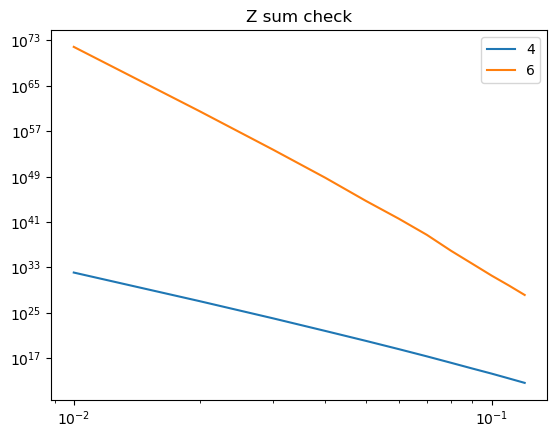

In [342]:
Z_sum_check = []

for i, p in enumerate(probabilities):
    free_energies_4 = free_energies_batch[i][0]
    free_energies_6 = free_energies_batch[i][1]
    
    j = 1

    res1 = mp.fsum([mp.exp(f_class[0][j])+ mp.exp(f_class[1][j])\
                          +mp.exp(f_class[2][j])+mp.exp(f_class[3][j]) \
                                   for f_class in free_energies_4 ])/len(free_energies_4) 
    
    res2 = mp.fsum([mp.exp(f_class[0][j])+ mp.exp(f_class[1][j])\
                          +mp.exp(f_class[2][j])+mp.exp(f_class[3][j]) \
                                   for f_class in free_energies_6 ])/len(free_energies_6) 
    Z_sum_check.append([res1,res2])
    
    
plt.figure
plt.plot(probabilities, Z_sum_check,label=["4","6"])
plt.title("Z sum check")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

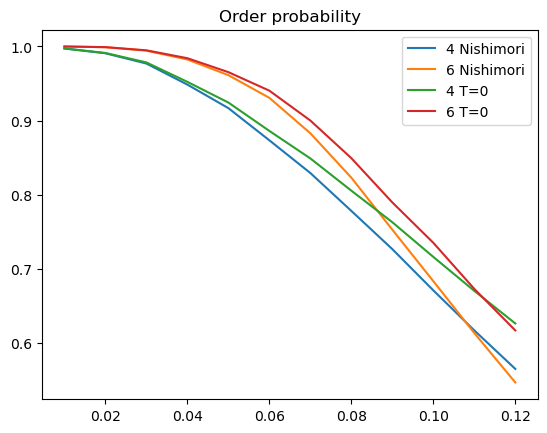

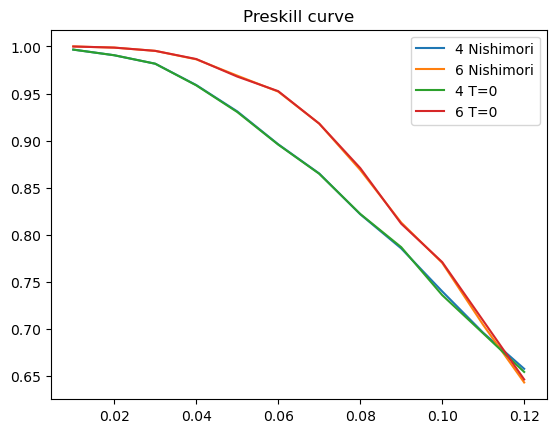

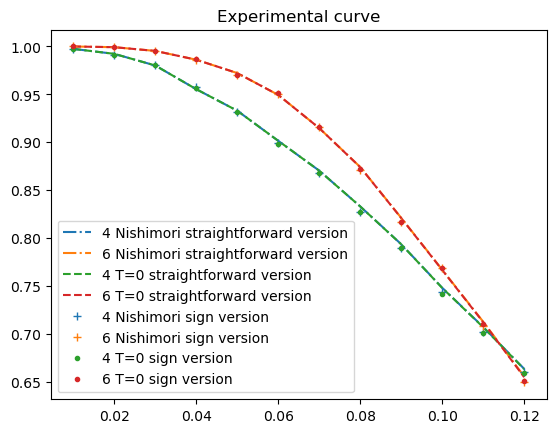

In [343]:
plt.figure
plt.plot(probabilities, order_probability,label=["4 Nishimori","6 Nishimori"])
plt.plot(probabilities, order_probability_T0,label=["4 T=0","6 T=0"])

plt.title("Order probability")
plt.legend()
plt.show()
             
plt.figure
plt.plot(probabilities, optimal_curve,label=["4 Nishimori","6 Nishimori"])
plt.plot(probabilities, mwpm_curve,label=["4 T=0","6 T=0"])

plt.title("Preskill curve")
plt.legend()
plt.show()

plt.figure
plt.plot(probabilities, experimental_curve_new,"-.",label=["4 Nishimori straightforward version","6 Nishimori straightforward version"])
plt.plot(probabilities, experimental_curve_new_T0,"--",label=["4 T=0 straightforward version","6 T=0 straightforward version"])
plt.gca().set_prop_cycle(None)
plt.plot(probabilities, experimental_curve,"+",label=["4 Nishimori sign version","6 Nishimori sign version"])
plt.plot(probabilities, experimental_curve_T0,".",label=["4 T=0 sign version","6 T=0 sign version"])


plt.title("Experimental curve")
plt.legend()
plt.show()


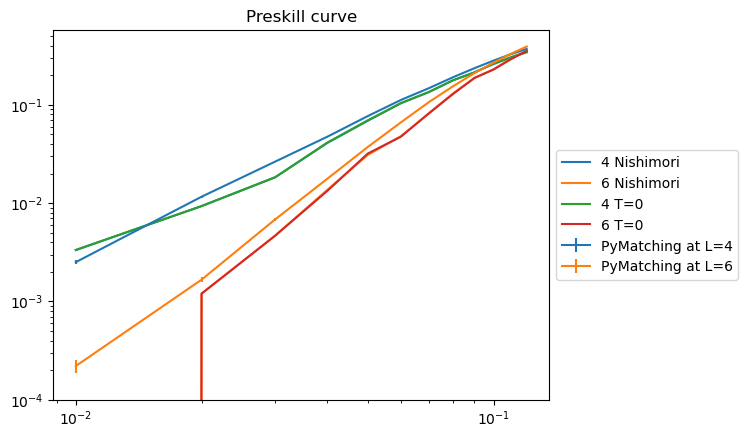

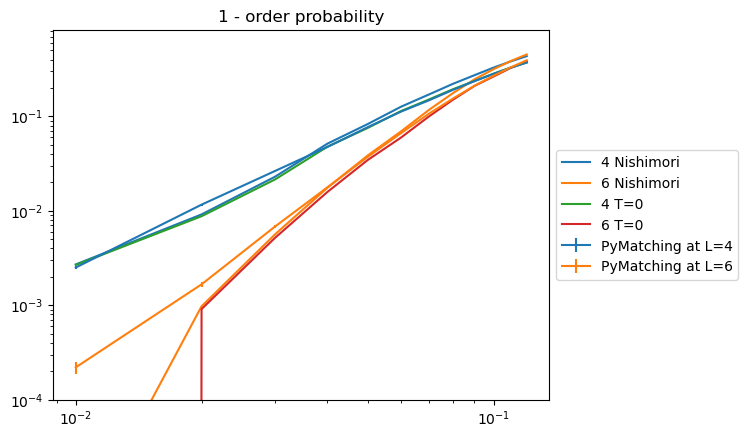

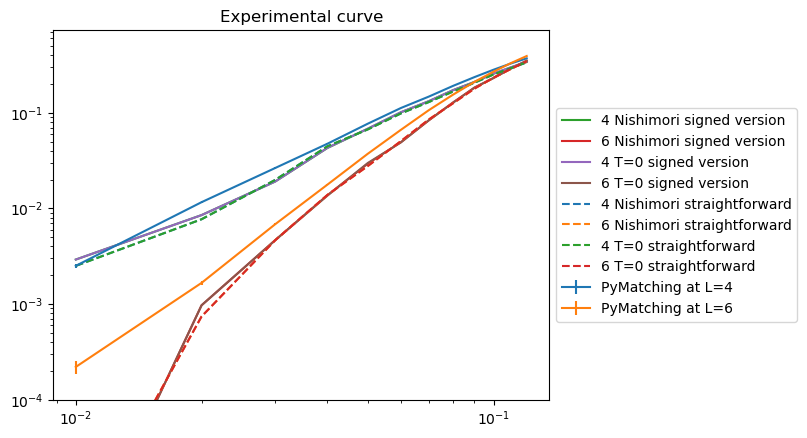

In [344]:

plt.figure

for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))
    
plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(optimal_curve))],label="4 Nishimori")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(optimal_curve))],label="6 Nishimori")
plt.plot(probabilities, [1-mwpm_curve[j][0] for j in range(len(optimal_curve))], label= "4 T=0")
plt.plot(probabilities, [1-mwpm_curve[j][1] for j in range(len(optimal_curve))], label= "6 T=0")


plt.title("Preskill curve")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()



plt.figure
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))
    
plt.gca().set_prop_cycle(None)

    
plt.plot(probabilities, [1-order_probability[j][0] for j in range(len(order_probability))],label="4 Nishimori")
plt.plot(probabilities, [1-order_probability[j][1] for j in range(len(order_probability))],label="6 Nishimori")
plt.plot(probabilities, [1-order_probability_T0[j][0] for j in range(len(order_probability))], label = "4 T=0")
plt.plot(probabilities, [1-order_probability_T0[j][1] for j in range(len(order_probability))], label = "6 T=0")


plt.title("1 - order probability")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()


plt.figure
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))
    
    

plt.plot(probabilities, [1-experimental_curve[j][0] for j in range(len(experimental_curve))],label="4 Nishimori signed version")
plt.plot(probabilities, [1-experimental_curve[j][1] for j in range(len(experimental_curve))],label="6 Nishimori signed version")
plt.plot(probabilities, [1-experimental_curve_T0[j][0] for j in range(len(experimental_curve))],label="4 T=0 signed version")
plt.plot(probabilities, [1-experimental_curve_T0[j][1] for j in range(len(experimental_curve))],label="6 T=0 signed version")
plt.gca().set_prop_cycle(None)
plt.plot(probabilities, [1-experimental_curve_new[j][0] for j in range(len(experimental_curve))],"--",label="4 Nishimori straightforward")
plt.plot(probabilities, [1-experimental_curve_new[j][1] for j in range(len(experimental_curve))],"--",label="6 Nishimori straightforward")
plt.plot(probabilities, [1-experimental_curve_new_T0[j][0] for j in range(len(experimental_curve))],"--",label="4 T=0 straightforward")
plt.plot(probabilities, [1-experimental_curve_new_T0[j][1] for j in range(len(experimental_curve))],"--",label="6 T=0 straightforward")


plt.title("Experimental curve")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()


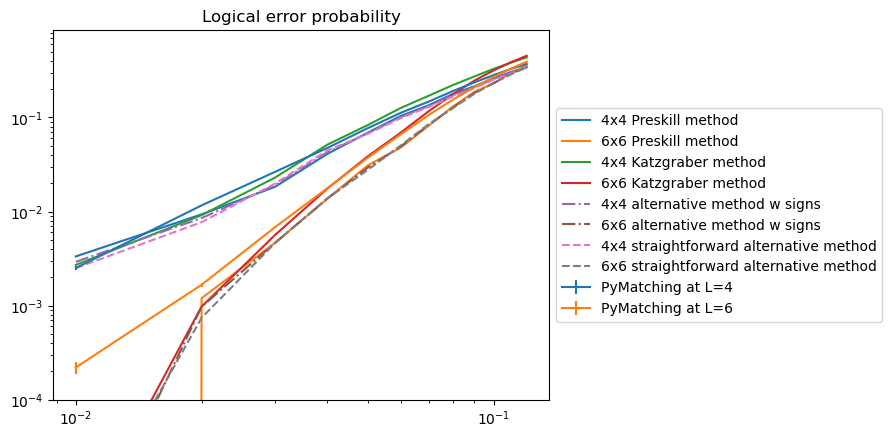

In [345]:
plt.figure


# plt.plot(probabilities, [p for p in probabilities],"--",color="black",label="Break-even")
# plt.plot(probabilities, [30*p**2 for p in probabilities],"--",color="gray",label="4 expected slope")
# plt.plot(probabilities, [150*p**3 for p in probabilities],"-.",color="gray",label="6 expected slope")


for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))
    
plt.gca().set_prop_cycle(None)




plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(optimal_curve))],label="4x4 Preskill method")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(optimal_curve))],label="6x6 Preskill method")

#plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-order_probability[j][0] for j in range(len(order_probability))],label="4x4 Katzgraber method")
plt.plot(probabilities, [1-order_probability[j][1] for j in range(len(order_probability))],label="6x6 Katzgraber method")

#plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-experimental_curve[j][0] for j in range(len(experimental_curve))],'-.',label="4x4 alternative method w signs")
plt.plot(probabilities, [1-experimental_curve[j][1] for j in range(len(experimental_curve))],'-.',label="6x6 alternative method w signs")

#plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-experimental_curve_new[j][0] for j in range(len(experimental_curve))],"--",label="4x4 straightforward alternative method")
plt.plot(probabilities, [1-experimental_curve_new[j][1] for j in range(len(experimental_curve))],"--",label="6x6 straightforward alternative method")



plt.title("Logical error probability")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()


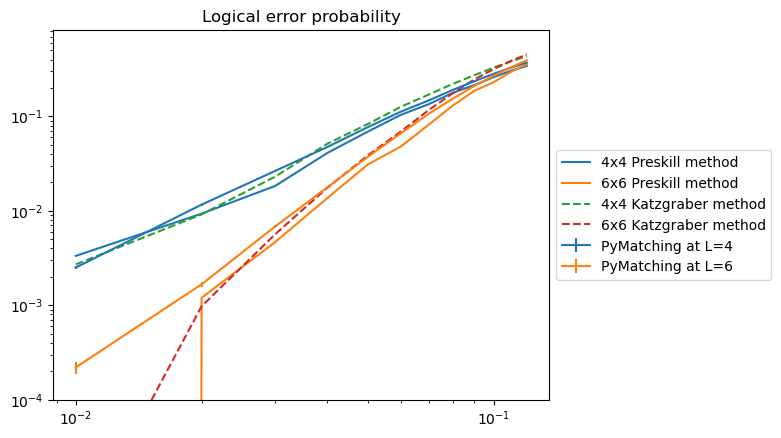

In [346]:
plt.figure


for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))
    
plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(optimal_curve))],label="4x4 Preskill method")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(optimal_curve))],label="6x6 Preskill method")

plt.plot(probabilities, [1-order_probability[j][0] for j in range(len(order_probability))],"--",label="4x4 Katzgraber method")
plt.plot(probabilities, [1-order_probability[j][1] for j in range(len(order_probability))],"--",label="6x6 Katzgraber method")


plt.title("Logical error probability")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()


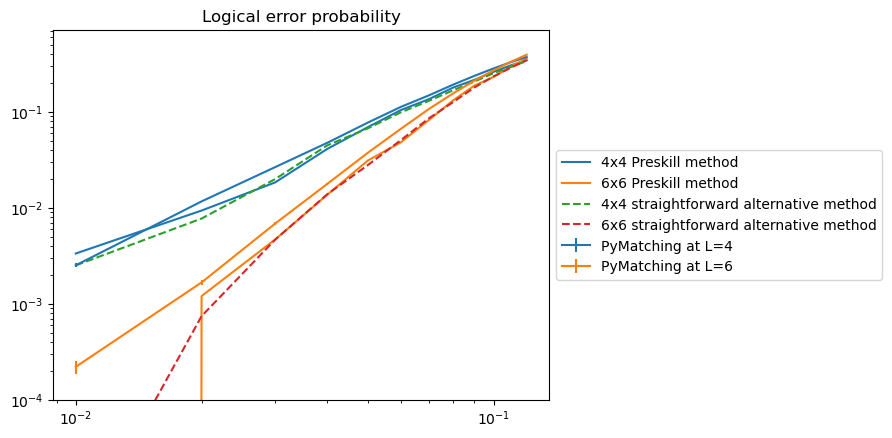

In [347]:
plt.figure


for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching at L={}".format(L))
    
plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(optimal_curve))],label="4x4 Preskill method")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(optimal_curve))],label="6x6 Preskill method")

plt.plot(probabilities, [1-experimental_curve_new[j][0] for j in range(len(experimental_curve))],"--",label="4x4 straightforward alternative method")
plt.plot(probabilities, [1-experimental_curve_new[j][1] for j in range(len(experimental_curve))],"--",label="6x6 straightforward alternative method")

plt.title("Logical error probability")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(bottom=1e-4, top=None)
plt.show()

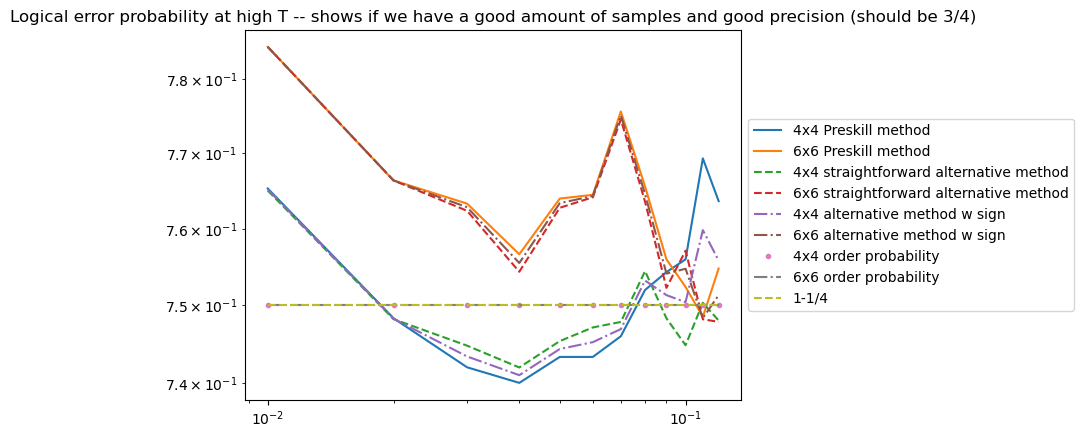

In [348]:
plt.figure


plt.gca().set_prop_cycle(None)

plt.plot(probabilities, [1-Preskill_curve_highT[j][0] for j in range(len(optimal_curve))],label="4x4 Preskill method")
plt.plot(probabilities, [1-Preskill_curve_highT[j][1] for j in range(len(optimal_curve))],label="6x6 Preskill method")

plt.plot(probabilities, [1-experimental_curve_new_highT[j][0] for j in range(len(experimental_curve))],"--",label="4x4 straightforward alternative method")
plt.plot(probabilities, [1-experimental_curve_new_highT[j][1] for j in range(len(experimental_curve))],"--",label="6x6 straightforward alternative method")



plt.plot(probabilities, [1-experimental_curve_highT[j][0] for j in range(len(experimental_curve))],"-.",label="4x4 alternative method w sign")
plt.plot(probabilities, [1-experimental_curve_highT[j][1] for j in range(len(experimental_curve))],"-.",label="6x6 alternative method w sign")


plt.plot(probabilities, [1-order_probability_highT[j][0] for j in range(len(experimental_curve))],".",label="4x4 order probability")
plt.plot(probabilities, [1-order_probability_highT[j][1] for j in range(len(experimental_curve))],"-.",label="6x6 order probability")

plt.plot(probabilities,[1-1/4 for j in range(len(probabilities))],"--", label="1-1/4")


plt.title("Logical error probability at high T -- shows if we have a good amount of samples and good precision (should be 3/4)")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

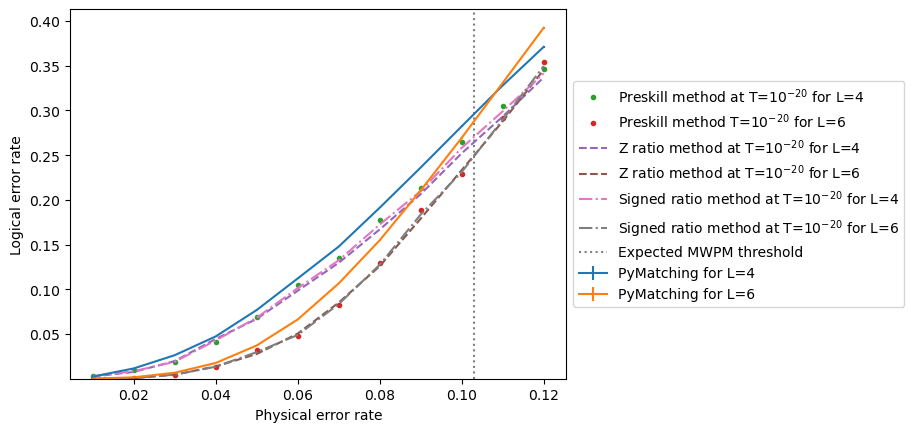

In [349]:
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching for L={}".format(L))
    
    
    
plt.plot(probabilities, [1-mwpm_curve[j][0] for j in range(len(experimental_curve))],".",label=r"Preskill method at T=$10^{-20}$ for L=4")
plt.plot(probabilities, [1-mwpm_curve[j][1] for j in range(len(experimental_curve))],".",label=r"Preskill method T=$10^{-20}$ for L=6")





plt.plot(probabilities, [1-experimental_curve_new_T0[j][0] for j in range(len(experimental_curve))],"--",label=r"Z ratio method at T=$10^{-20}$ for L=4")
plt.plot(probabilities, [1-experimental_curve_new_T0[j][1] for j in range(len(experimental_curve))],"--",label=r"Z ratio method at T=$10^{-20}$ for L=6")





plt.plot(probabilities, [1-experimental_curve_T0[j][0] for j in range(len(experimental_curve))],"-.",label=r"Signed ratio method at T=$10^{-20}$ for L=4")
plt.plot(probabilities, [1-experimental_curve_T0[j][1] for j in range(len(experimental_curve))],"-.",label=r"Signed ratio method at T=$10^{-20}$ for L=6")



plt.axvline(x=0.1031,color="gray",label="Expected MWPM threshold",linestyle="dotted")


plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")

#plt.xscale('log')
#plt.yscale('log')
plt.ylim(bottom=1e-4, top=None)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [350]:
print("Observed logical failures:")
print([float(1-mwpm_curve[j][0])*len(free_energies_batch[j][0]) for j in range(len(mwpm_curve))])
print([float(1-mwpm_curve[j][1])*len(free_energies_batch[j][0]) for j in range(len(mwpm_curve))])

print("\nSample sizes:")
print([len(free_energies_batch[j][0]) for j in range(len(mwpm_curve))])
print([len(free_energies_batch[j][1]) for j in range(len(mwpm_curve))])

Observed logical failures:
[10.0, 28.000000000000004, 55.0, 124.0, 209.0, 313.0, 406.0, 534.0, 640.0, 792.9999999999999, 915.0, 1038.0]
[0.0, 3.5999999999999996, 14.000000000000002, 40.0, 96.0, 142.5, 246.0, 387.6, 565.2, 687.5999999999999, 874.5, 1062.0]

Sample sizes:
[3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000]
[3000, 2500, 3000, 3000, 1000, 2000, 2500, 2500, 2500, 2500, 2000, 2500]


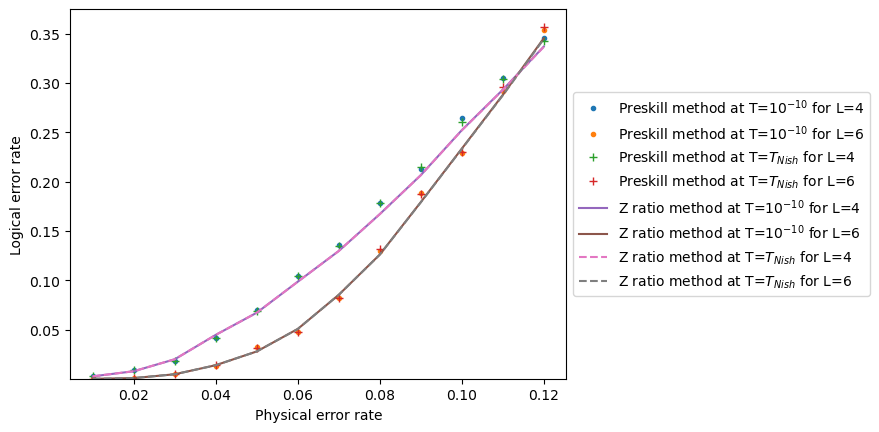

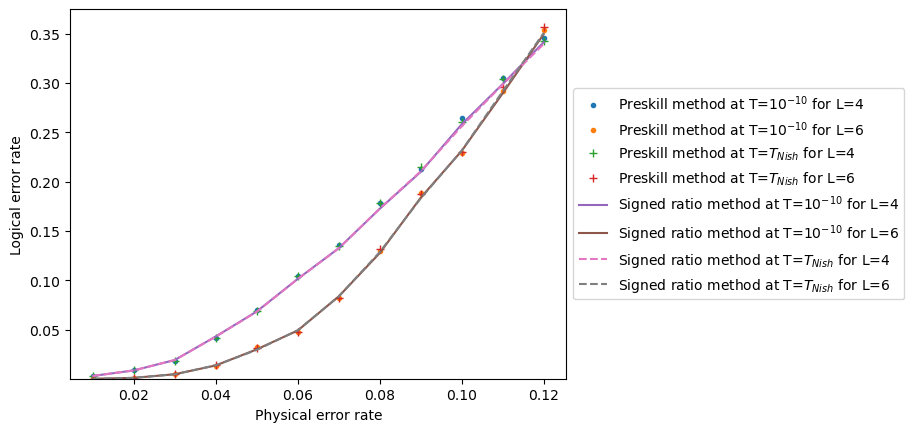

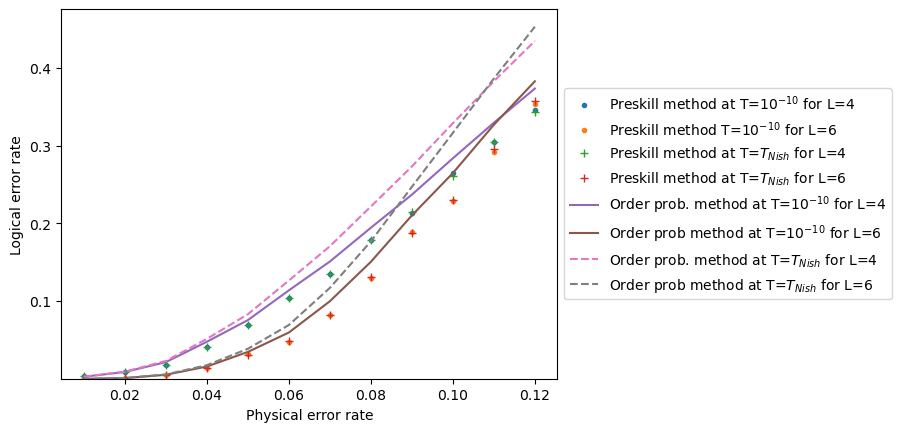

In [351]:
plt.figure()
 
plt.plot(probabilities, [1-mwpm_curve[j][0] for j in range(len(experimental_curve))],".",label=r"Preskill method at T=$10^{-10}$ for L=4")
plt.plot(probabilities, [1-mwpm_curve[j][1] for j in range(len(experimental_curve))],".",label=r"Preskill method at T=$10^{-10}$ for L=6")


plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(experimental_curve))],"+",label=r"Preskill method at T=$T_{Nish}$ for L=4")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(experimental_curve))],"+",label=r"Preskill method at T=$T_{Nish}$ for L=6")

    
plt.plot(probabilities, [1-experimental_curve_new_T0[j][0] for j in range(len(experimental_curve))],label=r"Z ratio method at T=$10^{-10}$ for L=4")
plt.plot(probabilities, [1-experimental_curve_new_T0[j][1] for j in range(len(experimental_curve))],label=r"Z ratio method at T=$10^{-10}$ for L=6")


plt.plot(probabilities, [1-experimental_curve_new[j][0] for j in range(len(experimental_curve))],"--",label=r"Z ratio method at T=$T_{Nish}$ for L=4")
plt.plot(probabilities, [1-experimental_curve_new[j][1] for j in range(len(experimental_curve))],"--",label=r"Z ratio method at T=$T_{Nish}$ for L=6")


plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")


# plt.xscale('log')
# plt.yscale('log')

plt.ylim(bottom=1e-4, top=None)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()





plt.figure()
 
plt.plot(probabilities, [1-mwpm_curve[j][0] for j in range(len(experimental_curve))],".",label=r"Preskill method at T=$10^{-10}$ for L=4")
plt.plot(probabilities, [1-mwpm_curve[j][1] for j in range(len(experimental_curve))],".",label=r"Preskill method at T=$10^{-10}$ for L=6")


plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(experimental_curve))],"+",label=r"Preskill method at T=$T_{Nish}$ for L=4")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(experimental_curve))],"+",label=r"Preskill method at T=$T_{Nish}$ for L=6")

    
plt.plot(probabilities, [1-experimental_curve_T0[j][0] for j in range(len(experimental_curve))],label=r"Signed ratio method at T=$10^{-10}$ for L=4")
plt.plot(probabilities, [1-experimental_curve_T0[j][1] for j in range(len(experimental_curve))],label=r"Signed ratio method at T=$10^{-10}$ for L=6")


plt.plot(probabilities, [1-experimental_curve[j][0] for j in range(len(experimental_curve))],"--",label=r"Signed ratio method at T=$T_{Nish}$ for L=4")
plt.plot(probabilities, [1-experimental_curve[j][1] for j in range(len(experimental_curve))],"--",label=r"Signed ratio method at T=$T_{Nish}$ for L=6")


plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")


# plt.xscale('log')
# plt.yscale('log')

plt.ylim(bottom=1e-4, top=None)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()




plt.figure()

plt.plot(probabilities, [1-mwpm_curve[j][0] for j in range(len(experimental_curve))],".",label=r"Preskill method at T=$10^{-10}$ for L=4")
plt.plot(probabilities, [1-mwpm_curve[j][1] for j in range(len(experimental_curve))],".",label=r"Preskill method T=$10^{-10}$ for L=6")

    
plt.plot(probabilities, [1-optimal_curve[j][0] for j in range(len(experimental_curve))],"+",label=r"Preskill method at T=$T_{Nish}$ for L=4")
plt.plot(probabilities, [1-optimal_curve[j][1] for j in range(len(experimental_curve))],"+",label=r"Preskill method at T=$T_{Nish}$ for L=6")


plt.plot(probabilities, [1-order_probability_T0[j][0] for j in range(len(experimental_curve))],label=r"Order prob. method at T=$10^{-10}$ for L=4")
plt.plot(probabilities, [1-order_probability_T0[j][1] for j in range(len(experimental_curve))],label=r"Order prob method at T=$10^{-10}$ for L=6")

plt.plot(probabilities, [1-order_probability[j][0] for j in range(len(experimental_curve))],"--",label=r"Order prob. method at T=$T_{Nish}$ for L=4")
plt.plot(probabilities, [1-order_probability[j][1] for j in range(len(experimental_curve))],"--",label=r"Order prob method at T=$T_{Nish}$ for L=6")

plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")

# plt.xscale('log')
# plt.yscale('log')

plt.ylim(bottom=1e-4, top=None)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [352]:
classes = [1,-1,1,-1]
i_max = classes.index(min(classes))
print(i_max)

print(sum([x == min(classes) for x in classes]))


list(np.where(np.asarray(classes) == min(classes))[0])

1
2


[1, 3]

# Note: MWPM is actually not quite the same as setting T=0, due to energy degeneracies

In [371]:
def mwpm_result(e_class, f_class):
    #Decoder picks a class based on lowest energy
    classes = [e_class[0],e_class[1],e_class[2],e_class[3]]
    i_max = classes.index(min(classes))
    
    #if i_max is not zero, decoder fails (we encountered a configuration with higher E than lowest)
    result = 0
    
    if i_max == 0:
        #If it is zero, decoder may succeed, but we need to account for that there could be several equivalent choices
        #We assume that the MWPM decoder will pick among the possible classes with equal probability
        result = 1/sum([x == min(classes) for x in classes])
        
          
    return result





def mwpm_result_new(e_class, f_class):
    #Decoder picks a class based on lowest energy
    classes = [e_class[0],e_class[1],e_class[2],e_class[3]]
    i_max = classes.index(min(classes))
    

    
        
    #If there are multiple classes with same lowest energy, pick one at random
    #We assume MWPM would find one at random, but most likely the sparse blossom
    #would prioritize some over others, since it takes advantage of being below threshold
    indices = list(np.where(np.asarray(classes) == min(classes))[0])
    i_max = np.random.choice(indices)
    
    
    #if i_max is not zero, decoder fails (picked other class than we're in)
    result = 0
    
    if i_max == 0:
        result = 1
          
    return result




#j=1 is assumed to correspond to the Nishimori temperature
def mwpm_fraction(e_class, f_class):
    
    #Decoder picks a class based on lowest energy
    classes = [e_class[0],e_class[1],e_class[2],e_class[3]]
    i_max = classes.index(min(classes))
    
    #If there are several, decoder arbitrarily picks one at random
    indices = list(np.where(np.asarray(classes) == min(classes))[0])
    i_max = np.random.choice(indices)
    
    
    #We find the likelihood of actually being in that class
    #Here, convention is that j=1 is Nishimori, j=0 is T=0, other temperatures are j>1
    result = ((1/(mp.exp(f_class[0][1] - f_class[i_max][1])\
                  +mp.exp(f_class[1][1] - f_class[i_max][1])\
                  +mp.exp(f_class[2][1] - f_class[i_max][1])\
                  +mp.exp(f_class[3][1] - f_class[i_max][1])))\
             *(1/sum([mp.exp(f_class[i][1] - f_class[i_max][1]) for i in indices])))

    
    
    return result








new_mwpm_curve = []

new_mwpm_fraction_curve = []


for i, p in enumerate(probabilities):
    lowest_energies_4 = lowest_energies_batch[i][0]
    lowest_energies_6 = lowest_energies_batch[i][1]
    
    
    free_energies_4 = free_energies_batch[i][0]
    free_energies_6 = free_energies_batch[i][1]
    
    res1 = mp.fsum([mwpm_result(e_class,f_class) for e_class in lowest_energies_4 ])/len(lowest_energies_4) 
    res2 = mp.fsum([mwpm_result(e_class,f_class) for e_class in lowest_energies_6 ])/len(lowest_energies_6) 
    new_mwpm_curve.append([res1,res2])
    
    
    
    res1 = mp.fsum([mwpm_fraction(e_class,f_class) for e_class in lowest_energies_4 ])/len(lowest_energies_4) 
    res2 = mp.fsum([mwpm_fraction(e_class,f_class) for e_class in lowest_energies_6 ])/len(lowest_energies_6) 
    new_mwpm_fraction_curve.append([res1,res2])
    

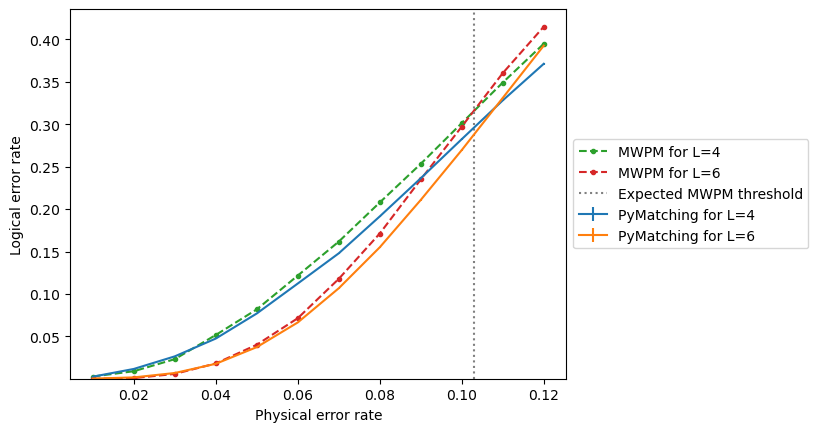

In [372]:
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching for L={}".format(L))
    
plt.plot(probabilities, [1-new_mwpm_curve[j][0] for j in range(len(experimental_curve))],".--",label=r"MWPM for L=4")
plt.plot(probabilities, [1-new_mwpm_curve[j][1] for j in range(len(experimental_curve))],".--",label=r"MWPM for L=6")


# plt.plot(probabilities, [1-new_mwpm_fraction_curve[j][0] for j in range(len(experimental_curve))],"+--",label=r"MWPM fraction for L=4")
# plt.plot(probabilities, [1-new_mwpm_fraction_curve[j][1] for j in range(len(experimental_curve))],"+--",label=r"MWPM fraction for L=6")





plt.axvline(x=0.1031,color="gray",label="Expected MWPM threshold",linestyle="dotted")

plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")

#plt.xscale('log')
#plt.yscale('log')
plt.ylim(bottom=1e-4, top=None)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()